In [1]:
# using Plots
using LinearAlgebra
using SparseArrays
using PyPlot
using Revise

myBase = "/home/soshala/SMEAR-PhD/SMEAR/smear_julia/"

include(myBase * "smear_fem/src/SmearFEM.jl")

Main.PostProcess

In [2]:
# # test case 
r0 = 2
r1 = 4
theta0 = 0
theta1 = pi/2
ne = 10;
# h = (x1 - x0) / ne;

10

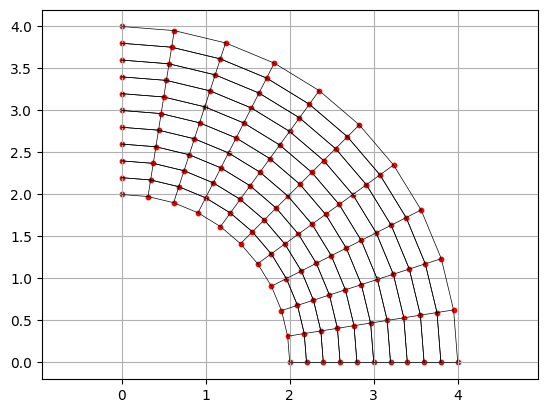

In [3]:
# set up mesh grid
function meshgrid_ring(r1,r2, theta1, theta2, ne)
    
    r = collect(range(r1, r2, length=ne+1))
    theta = collect(range(theta1, theta2, length=ne+1))

    NodeList = zeros(2,(ne+1)*(ne+1))

    k = 1
    for i in 1:ne+1
        for j in 1:ne+1
            NodeList[1,k] = r[i]*sin(theta[j])
            NodeList[2,k] = r[i]*cos(theta[j])
            k = k + 1
        end
    end

    IEN = zeros(Int64,ne*ne,4)
    
    l = 1
    for i in 1:ne
        for j in 1:ne
            IEN[l,1] = (i-1)*(ne+1) + j
            IEN[l,2] = (i-1)*(ne+1) + j + 1
            IEN[l,3] = i*(ne+1) + j + 1
            IEN[l,4] = i*(ne+1) + j
            l = l + 1
        end
    end

    return NodeList, IEN
end

NodeList, IEN = meshgrid_ring(r0,r1,theta0,theta1,ne)

fig1 = plt.figure()
ax = fig1.add_subplot(111)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.scatter(NodeList[1,:],NodeList[2,:],s=10,c="r")
ax.axis("equal")
ax.grid("on")

gcf()

[1.0, 1.0]


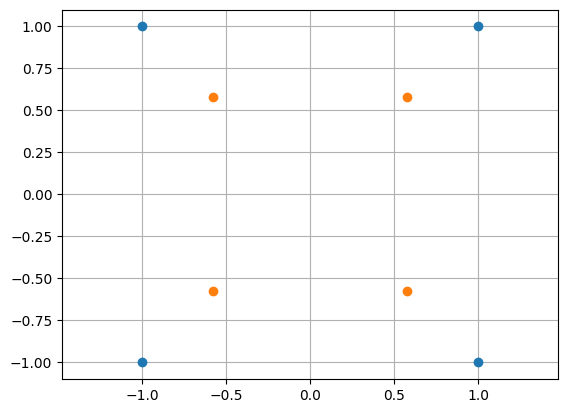

In [4]:
# check gaussianQuadrature function for a square element [-1,1]x[-1,1]

x_1 = -1
x_2 = 1
y_1 = -1
y_2 = 1

xi_, w_xi = fem.gaussianQuadrature(x_1,x_2)
eta_, w_eta = fem.gaussianQuadrature(y_1,y_2)

x = [xi_[1], xi_[2], xi_[2], xi_[1]]
y = [eta_[1], eta_[1], eta_[2], eta_[2]]

println(w_xi.*w_eta)

fig2 = plt.figure() 
plt.plot([x_1,x_2,x_1,x_2],[y_1,y_1,y_2,y_2],"o")
plt.plot(x,y,"o")
plt.axis("equal")  
plt.grid("on")
plt.show()

gcf()

In [5]:
function setboundaryCond(NodeList, ne, r0, r1)
    # set dirichlet boundary conditions
    q_d = zeros((ne+1)*(ne+1),1)
    q_n = zeros((ne+1)*(ne+1),1)
    Dbound1 = r0
    Dbound2 = r1
    Nbound = 0

    # definition of the constraint matrix
    C = Matrix{Int}(I,(ne+1)*(ne+1),(ne+1)*(ne+1))

    for n1 in 1:length(q_d)
        coord = NodeList[:,n1] # get the coordinates of the node
        if floor(coord[1]^2 + coord[2]^2) == Dbound1^2 # bottom boundary
            q_d[n1] = 0
        elseif ceil(coord[1]^2 + coord[2]^2) == Dbound2^2 # top boundary
            q_d[n1] = 1
        end
    end

    for n in 1:length(q_n)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end
    
    C = C[:,(ne+2):((ne+1)*(ne+1)-(ne+1))]
    
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne, r0, r1);


In [6]:
K = SmearFEM.assemble_system(ne, NodeList, IEN)

q_d, q_n, C = setboundaryCond(NodeList, ne)

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

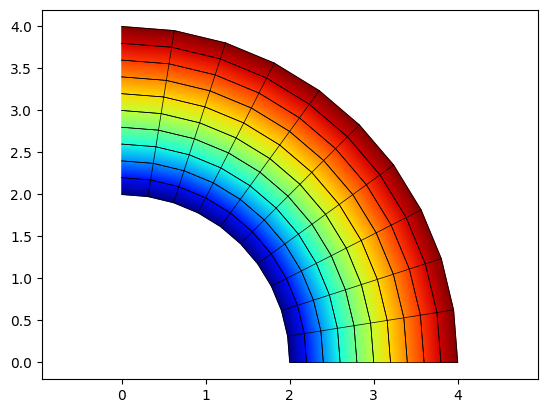

In [8]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
qList = PostProcess.noramlize(q, IEN)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    c = qList[i,:]
    cmap = PostProcess.truncate_colormap(maximum(c), minimum(c))
    ax.tripcolor(x, y, c, cmap=cmap,shading="gouraud" )
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.axis("equal")
gcf()